In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, metrics, activations
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open("download-cats", "w") as f:
  f.write("""
  if [ ! -d FACES128x128 ]; then
    wget "https://www.dropbox.com/s/mm1bwgfk65cxtv3/FACES128x128.zip?dl=1" -O "FACES128x128.zip"
    unzip "FACES128x128.zip" > /dev/null
    rm "FACES128x128.zip"
  fi
  """)
!bash download-cats

--2021-08-26 21:41:52--  https://www.dropbox.com/s/mm1bwgfk65cxtv3/FACES128x128.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/mm1bwgfk65cxtv3/FACES128x128.zip [following]
--2021-08-26 21:41:52--  https://www.dropbox.com/s/dl/mm1bwgfk65cxtv3/FACES128x128.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbf5a8ac8388b7d2f450f315c9b.dl-eu.dropboxusercontent.com/cd/0/get/BU-m3oP8X-Ttc84wLgnKGOtPj5iUZmK_esFogbDVWyeUwBumiUPD8dj0rU2jvgtEPiktXLbEWa3oPn5Oyjw4UnTZVa2PPWI1XBDYdIoEnCkhytUNtDKkp7_NnuIN4SF947wwlQW5uLHiG0akhfHLjUMj/file?dl=1# [following]
--2021-08-26 21:41:53--  https://ucbf5a8ac8388b7d2f450f315c9b.dl-eu.dropboxusercontent.com/cd/0/get/BU-m3oP8X-Ttc84wLgnKGOtPj5iUZmK_esFogbDVWyeUwBumiUPD8dj0rU2jvgtEPik

In [3]:
 def normalize(x):
  # Normalizes to [-1, 1]
  return (x - 127.5) / 127.5

 def load_image(path, size = None):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  image = tf.cast(image, tf.float32)
  image = tf.reshape(image, [128, 128, 3])
  image = normalize(image)
  if size is not None:
    image = tf.image.resize(image, (size, size))

  return image

In [4]:
TRAINING_SET_SIZE = 10_000
BATCH_SIZE = 64
IMAGE_SIZE = 64 # Max 128

dataset = tf.data.Dataset.list_files("FACES128x128/*.jpg")
dataset = dataset \
    .map(lambda path: load_image(path, IMAGE_SIZE), num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .shuffle(buffer_size = 50_000) \
    .batch(BATCH_SIZE, drop_remainder=True)



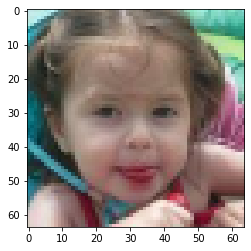

In [5]:
def to_image(img):
  img = img.reshape([IMAGE_SIZE, IMAGE_SIZE, 3])
  img = img * 127.5 + 127.5
  img = img.astype("uint8")
  return img

def show_image(img):
  img = to_image(img)
  plt.imshow(img)
  plt.show()

sample = next(iter(dataset)).numpy()[0]
show_image(sample)

In [6]:
# Definer diskriminator-modellen. I motsetning til klassifikatoren skal denne gi
# ut én output-verdi: hvor vidt bilde-input-en er autentisk (true) eller 
# generert (false). 

discriminator = Sequential([
    # (784)
    layers.Reshape((64, 64, 3), input_shape=(64, 64, 3)),
    # (64, 64, 3)

    layers.Conv2D(32, (5, 5), strides=(2,2), padding="same", activation="LeakyReLU"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    # (32, 32, 64)

    layers.Conv2D(64, (5, 5), strides=(2,2), padding="same", activation="LeakyReLU"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    # (16, 16, 64)

    layers.Conv2D(128, (5, 5), strides=(2,2), padding="same", activation="LeakyReLU"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    # (8, 8, 128)

    layers.Conv2D(256, (5, 5), strides=(2,2), padding="same", activation="LeakyReLU"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    # (4, 4, 256)
    
    layers.Flatten(),
    # (4*4*256)

    layers.Dense(units = 1)
    # (1)                        
])

discriminator.compile(loss = losses.BinaryCrossentropy(from_logits=True))
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

In [7]:
noise_dim = 100

# Definer generator-modellen. Denne skal ta inn en støy-vektor (en vektor med 
# størrelse lik noise_dim av tilfeldige flyttall) og gi ut et bilde.

generator = Sequential([
    layers.BatchNormalization( input_shape=(noise_dim,)),
    layers.Dense(units = 128 * 8 * 8, activation="LeakyReLU"),
    layers.BatchNormalization(),
    layers.Reshape((8, 8, 128)),
    # (8, 8, 256)

    layers.Conv2DTranspose(128, kernel_size=(5,5), strides = (2, 2), padding="same", activation="LeakyReLU"),
    layers.BatchNormalization(),
    # 16, 16, 256

    layers.Conv2DTranspose(64, kernel_size=(5,5), strides = (2, 2), padding="same", activation="LeakyReLU"),
    layers.BatchNormalization(),
    # 32, 32, 128

    layers.Conv2DTranspose(32, kernel_size=(5,5), strides = (2, 2), padding="same", activation="LeakyReLU"),
    layers.BatchNormalization(),
    # 64, 64, 64

    layers.Conv2DTranspose(3, kernel_size=(5,5), strides = (1, 1), padding="same", activation="tanh"),
    # 64, 64, 3
    layers.Reshape((64, 64, 3))
])


generator.compile(loss = losses.BinaryCrossentropy(from_logits = True))
generator.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8192)              32768     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       409728    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)       

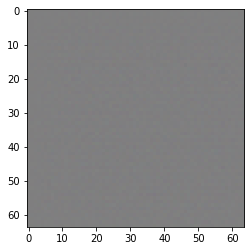

In [8]:
def generate_noise(dim, batch_size = 1):
  return tf.random.normal([batch_size, dim])

# Generer og viser et bilde fra den utrente generatoren

generated_image = generator(generate_noise(noise_dim)).numpy()

show_image(generated_image)


In [9]:
# Definerer optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5)

In [10]:
# Denne kan du kopiere fra en tidligere Notebook

@tf.function
def train_step(real_images):
  noise = generate_noise(dim = noise_dim, batch_size = BATCH_SIZE)

  with tf.GradientTape(persistent=True) as tape:

    fake_images = generator(noise)

    prediction_real = discriminator(real_images)
    prediction_fake = discriminator(fake_images)

    discriminator_loss = losses.binary_crossentropy(y_true=tf.ones_like(prediction_real), y_pred=prediction_real, from_logits=True) + losses.binary_crossentropy(y_true=tf.zeros_like(prediction_fake), y_pred=prediction_fake, from_logits=True)
    generator_loss = losses.binary_crossentropy(y_true=tf.ones_like(prediction_fake), y_pred=prediction_fake, from_logits=True)

  gradients_of_generator = tape.gradient(generator_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  gradients_of_discriminator = tape.gradient(discriminator_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  P_real = tf.reduce_mean(activations.sigmoid(prediction_real))
  P_fake = 1 - tf.reduce_mean(activations.sigmoid(prediction_fake))

  return tf.reduce_mean(discriminator_loss), tf.reduce_mean(generator_loss), P_real, P_fake


In [11]:
def show_image_grid(images):
  N = images.shape[0]

  fig = plt.figure(figsize=(3, 3))
  fig.set_size_inches(10, 10)

  for i in range(N):
      plt.subplot(3, 3, i+1)
      img = to_image(images[i])
      plt.imshow(img)
      plt.axis('off')

  plt.show()

In [12]:
# Tips og triks
#
# Er diskriminatoren mye sterkere enn generatoren (dette ser du hvis 
# diskriminatoren konsekvent vurderer både ekte og falske bilder med
# høy treffsikkerhet)?
# - Kan f.eks. kompensere med en lavere learning rate for diskriminatoren. 

In [13]:
EPOCHS = 50

noise_for_training_visualization = generate_noise(noise_dim, batch_size = 9)

for epoch in range(EPOCHS):

  print("Epoch", epoch),

  for step, batch in enumerate(dataset):
    Ld, Lg, Pr, Pf = train_step(batch)

    if step % 10 == 0:
      print("Step {}. Ld={}, Lg={}, Pr={}, Pf={}".format(step, Ld, Lg, Pr, Pf))

  show_image_grid(generator(noise_for_training_visualization).numpy())


  

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Denne kan du bruke til å utforske generatoren!

from ipywidgets import interact

p1 = generate_noise(noise_dim)
p2 = generate_noise(noise_dim)
p3 = generate_noise(noise_dim)

@interact(k1=(0, 1.0), k2=(0, 1.0))
def g(k1, k2):
    p = p1 + k1 * (p2 - p1) + k2 * (p3 - p1)
    show_image(generator(p).numpy())

interactive(children=(FloatSlider(value=0.5, description='k1', max=1.0), FloatSlider(value=0.5, description='k…